In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import sagemaker
#sess = sagemaker.Session()
#bucket = sess.default_bucket()                    # Set a default S3 bucket
#prefix = 'DEMO-automatic-model-tuning-xgboost-dm'
#bucket = "ibrahim-fyp"

In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d ruizgara/socofing
#!pip install tensorflow
#!pip install tensorflow-gpu

In [2]:
!pip install torch
!pip install torchvision

In [ ]:
#!unzip socofing.zip -d fingerprintgeneration/dataset/
import os
for i in os.listdir("fingerprintgeneration/dataset/fingerprintdataset/"):
    print(str(len(os.listdir("fingerprintgeneration/dataset/fingerprintdataset/"+i))) +" "+ i +" Images")

17931 Altered-Easy Images
6000 Real Images
14272 Altered-Hard Images
17067 Altered-Medium Images


**Importing the libraries**

In [3]:
import os                                   # os package
import time                                 # time package
import torch                                # root package
import torch.nn as nn                       # neural networks
import torch.optim as optim                 # Optimizers e.g. gradient descent, ADAM, etc. 
import torchvision.datasets as dset         # dataset representation
from torch.utils.data import DataLoader     # dataset loading
import torchvision.transforms as transforms # composable transforms
from torchvision.utils import make_grid, save_image
from torch.autograd import Variable

%matplotlib inline
import random                               # random package
import numpy as np                          # package for scientific computing 
import matplotlib.pyplot as plt             # visualization package
import matplotlib.image as mpimg
import matplotlib.animation as animation
import warnings                             # supress warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm      # progres package

# random seed everything
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
random_seed(17, True)

### Look at some d
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world.

There are 6000 Real Finger prints.


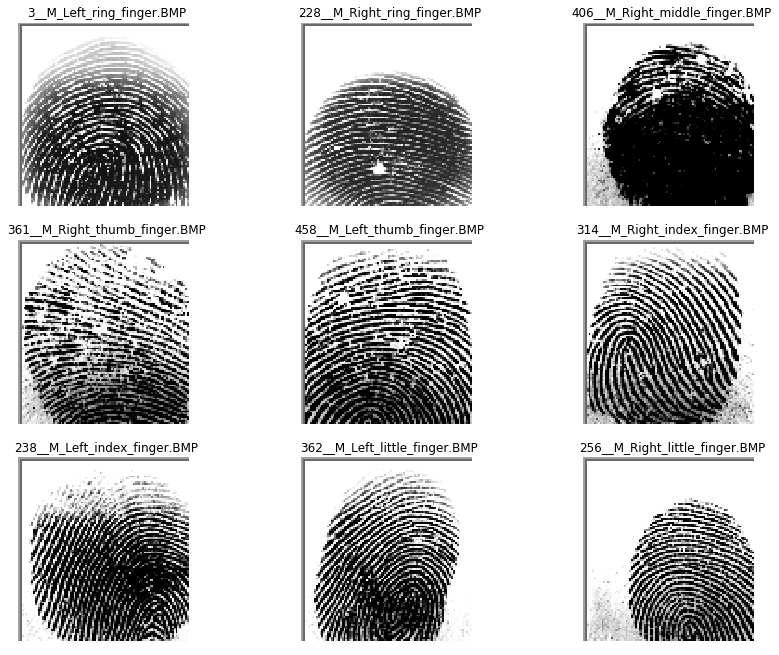

In [ ]:
PATH = 'fingerprintgeneration/dataset/fingerprintdataset/Real/'
images = os.listdir(PATH)
print(f'There are {len(images)} Real Finger prints.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Image Preprocessing

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = dset.ImageFolder('fingerprintgeneration/dataset/fingerprintdataset/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Weights
Defining the `weights_init` function

In [18]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator

In [10]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

### Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

### Training

### Parameters

In [6]:
!mkdir results

batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize models and optimizers

In [17]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

### Plot Loss per EPOCH

In [16]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Show generated images

In [15]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

### Training Loop

[1/100][864/1728] Loss_D: 1.3484 Loss_G: 1.3931 D(x): 0.5744 D(G(z)): 0.5222 / 0.2283
[1/100][1728/1728] Loss_D: 1.8959 Loss_G: 0.8871 D(x): 0.2029 D(G(z)): 0.2646 / 0.4022



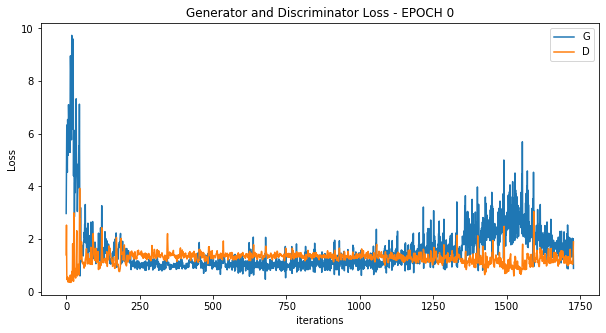

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


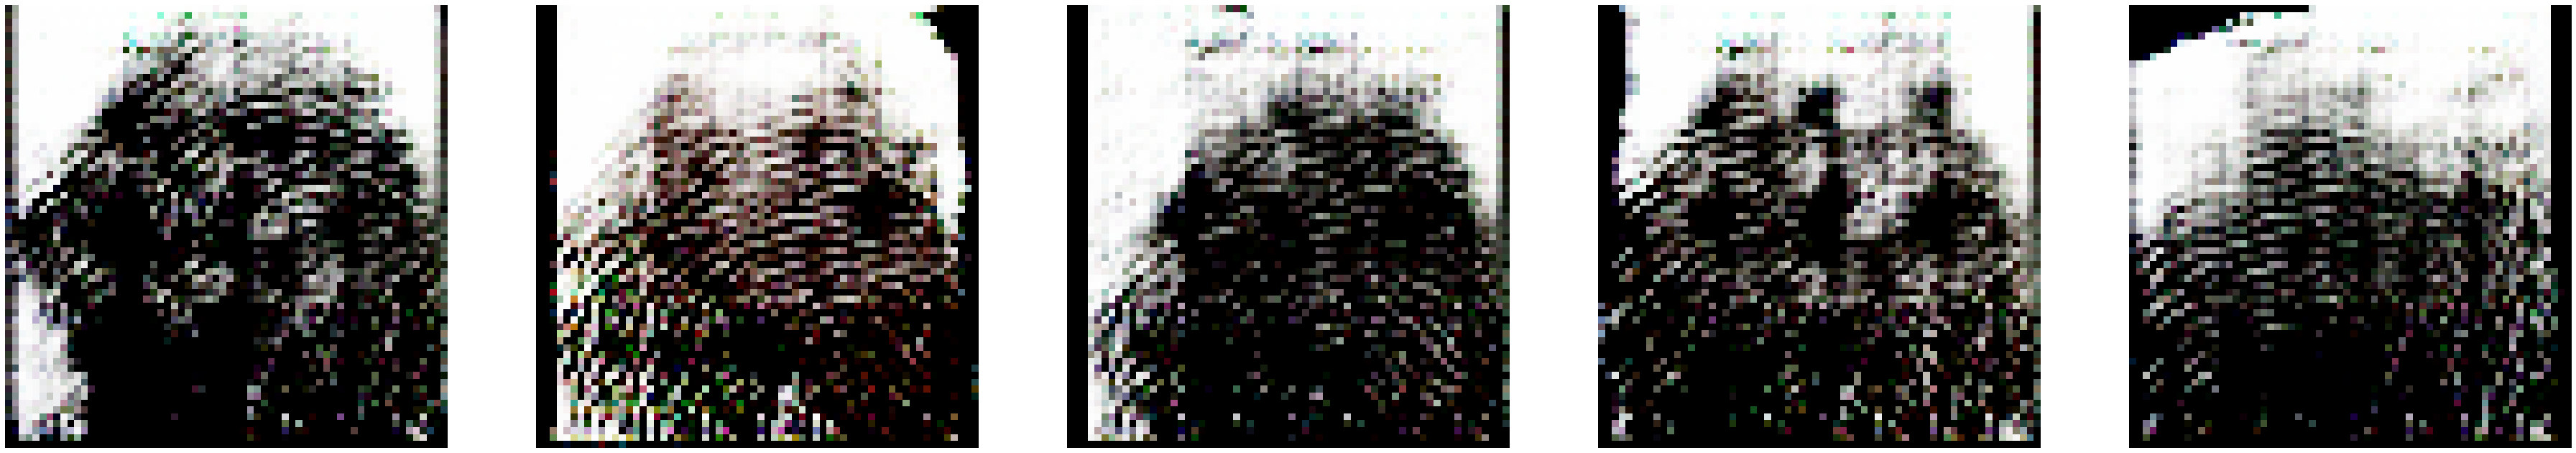

[2/100][864/1728] Loss_D: 1.2363 Loss_G: 1.5193 D(x): 0.3947 D(G(z)): 0.2340 / 0.2166
[2/100][1728/1728] Loss_D: 0.9456 Loss_G: 3.4707 D(x): 0.6755 D(G(z)): 0.3557 / 0.0229



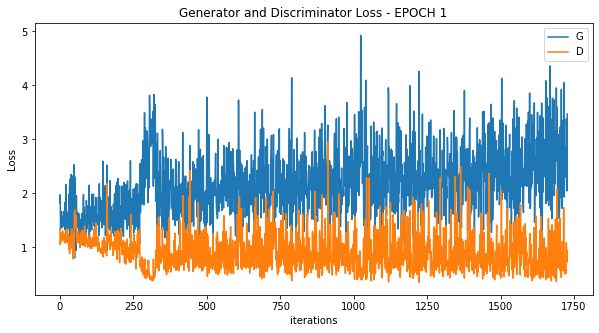

[3/100][864/1728] Loss_D: 1.7487 Loss_G: 1.2817 D(x): 0.1867 D(G(z)): 0.0710 / 0.2901
[3/100][1728/1728] Loss_D: 0.5092 Loss_G: 4.3949 D(x): 0.7278 D(G(z)): 0.0239 / 0.0136



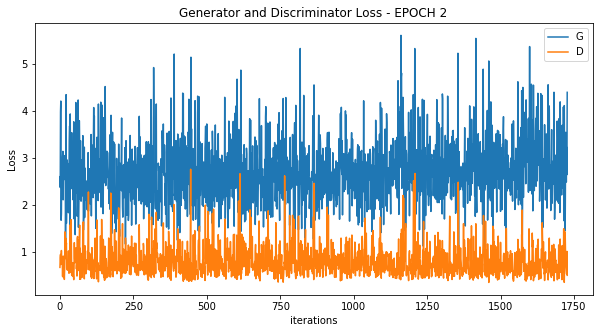

[4/100][864/1728] Loss_D: 0.7279 Loss_G: 3.1799 D(x): 0.5368 D(G(z)): 0.0246 / 0.0401
[4/100][1728/1728] Loss_D: 0.3863 Loss_G: 4.3960 D(x): 0.8878 D(G(z)): 0.0095 / 0.0112



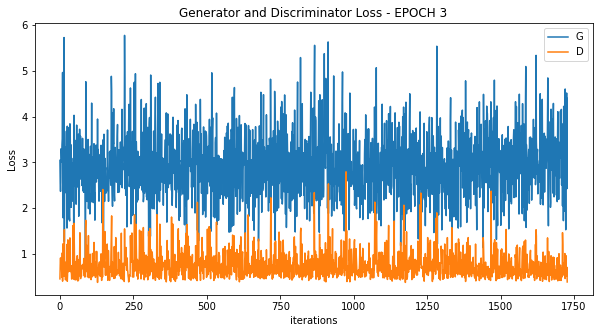

[5/100][864/1728] Loss_D: 0.4908 Loss_G: 2.7680 D(x): 0.7778 D(G(z)): 0.0528 / 0.0637
[5/100][1728/1728] Loss_D: 2.3416 Loss_G: 4.7314 D(x): 0.1744 D(G(z)): 0.0030 / 0.0614



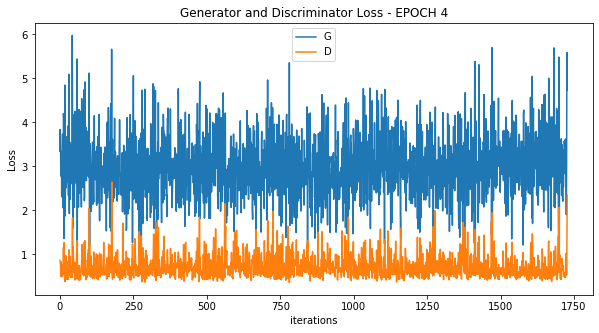

In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    torch.save(netG.state_dict(), 'fingerprintgeneration/model/generator.pth')
    torch.save(netD.state_dict(), 'fingerprintgeneration/model/discriminator.pth')
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)

In [ ]:
print (">> average EPOCH duration = ", np.mean(epoch_time))

In [ ]:
!pip install dcgan_pytorch

#### Generated Images

In [14]:

from torchvision.models.segmentation import deeplabv3_resnet50
import shutil

import torchvision.utils

# Load model weights.
state_dict = torch.load("/content/drive/MyDrive/model/generator.pth", map_location=device)
model = Generator()
model.load_state_dict(state_dict )
model.eval()
 # Start the verification mode of the model.
model.eval()

from torchvision.models.segmentation import deeplabv3_resnet50
import shutil

import torchvision.utils

# Load model weights.
state_dict = torch.load("/content/drive/MyDrive/model/discriminator.pth")
modeld = Discriminator()
modeld.load_state_dict(state_dict)
modeld.eval()
 # Start the verification mode of the model.
modeld.eval()
modeld

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [19]:
netG=model
netD=modeld
batch_size = real_images.size(0)
labels = torch.full((batch_size, 1), real_label, device=device)
output = netD(real_images)
errD_real = criterion(output, labels)
errD_real.backward()
D_x = output.mean().item()
        # train with fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
labels.fill_(fake_label)
output = netD(fake.detach())
errD_fake = criterion(output, labels)
errD_fake.backward()
D_G_z1 = output.mean().item()
errD = errD_real + errD_fake
optimizerD.step()
netG.zero_grad()
labels.fill_(real_label)  # fake labels are real for generator cost
output = netD(fake)
errG = criterion(output, labels)
errG.backward()
D_G_z2 = output.mean().item()
optimizerG.step()
        # Save Losses for plotting later
G_losses.append(errG.item())
D_losses.append(errD.item())
        
if (ii+1) % (len(train_loader)//2) == 0:
  print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
plot_loss (G_losses, D_losses, epoch)

NameError: ignored

In [ ]:
import os
if not os.path.exists('/content/drive/MyDrive/output'):
    os.mkdir('/content/drive/MyDrive/output')
netG=model 
im_batch_size = 50
n_images=10000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    #images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/content/drive/MyDrive/output/image_i_batch'+str(i_image)+'.png'))

  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: ignored

<Figure size 1800x1152 with 0 Axes>

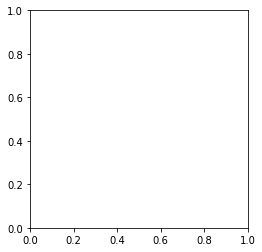

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    # ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.figure()
    plt.imshow(j)
    plt.show()

### Submission

#### Save models

In [ ]:
torch.save(netG.state_dict(), 'fingerprintgeneration/model/generator.pth')
torch.save(netD.state_dict(), 'fingerprintgeneration/model/discriminator.pth')